# Análise Titanic

**Introdução:** Este código avalia a sobrevivência dos passageiros que estavam no titanic durante seu naufrágio.

## Dataset analisado:

- PassengerId: Número de identificação do passageiro;
- Pclass     : Classe do passageiro no navio;
- Name       : Nome do passageiro;
- Sex        : Sexo do passageiro;
- Age        : Idade do passageiro;
- SibSp      : Número de irmãos/esposas no navio;
- Parch      : Número de pais/filhos no navio;
- Ticket     : Número do bilhete dos passageiros;
- Fare       : Valor pago pelo passageiro no bilhete;
- Cabin      : Cabine do passageiro no navio
- Embarked   : Local onde o passageiro embarcou.

## 1. Coleta de dados

In [1]:
#Desabilitando warnings indesejados.
import warnings
warnings.filterwarnings('ignore')

# Importando as bibliotecas para analisar os dados
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#Importando os dados
trainFile = pd.read_csv("https://raw.githubusercontent.com/rayanmst/Titanic/master/train.csv", index_col = 'PassengerId')
#Verificando
trainFile.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#verificando dimensões do DataFrame
print(trainFile.shape)

(891, 11)


## 2. Definindo funções para gráficos

In [4]:
#Esta função serve para tornar a exibição de um map de correlações de maneira mais fácil
def plot_correlation_map(df):
    corr = trainFile.corr()
    _ , ax = plt.subplots(figsize =(12 , 10))
    cmap = sns.diverging_palette(220 , 10 , as_cmap = True)
    _ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={'shrink':.9}, ax=ax, annot = True, annot_kws = {'fontsize':12})

## 3. Analisando algumas colunas

<Figure size 720x432 with 0 Axes>

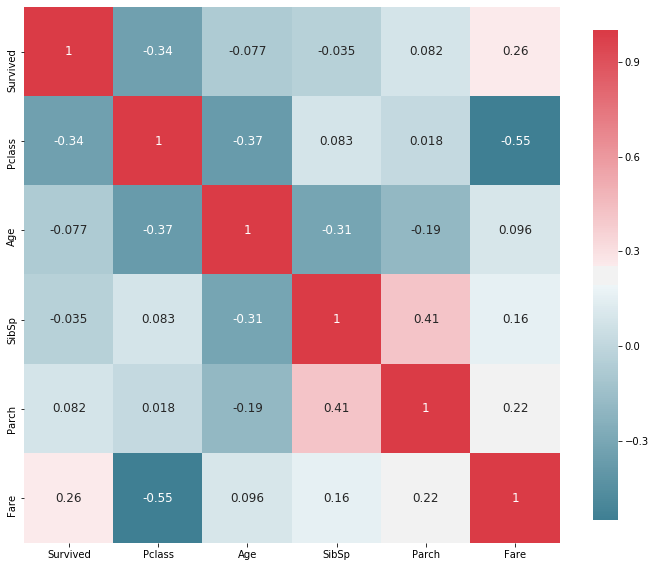

In [5]:
#Mostrando os gráficos no terminal
%matplotlib inline

#Definindo tamanho da figura
plt.figure(figsize=(10, 6))
#Verificando a correlação das colunas de tipos numéricos
plot_correlation_map(trainFile)

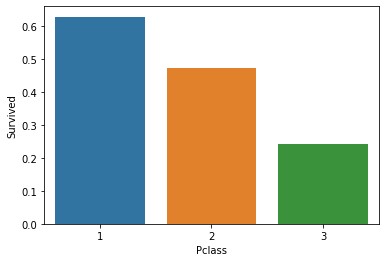

In [6]:
#Removendo colunas desnecessárias
del trainFile['Name']
del trainFile['SibSp']
del trainFile['Parch']
del trainFile['Cabin']
del trainFile['Ticket']

#Análise de relação entre classe e sobrevivência
classSurvivors = trainFile[['Pclass', 'Survived']].groupby(['Pclass'], 
      as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(y = classSurvivors['Survived'], x = classSurvivors['Pclass'])

Text(0.5, 0, 'Age')

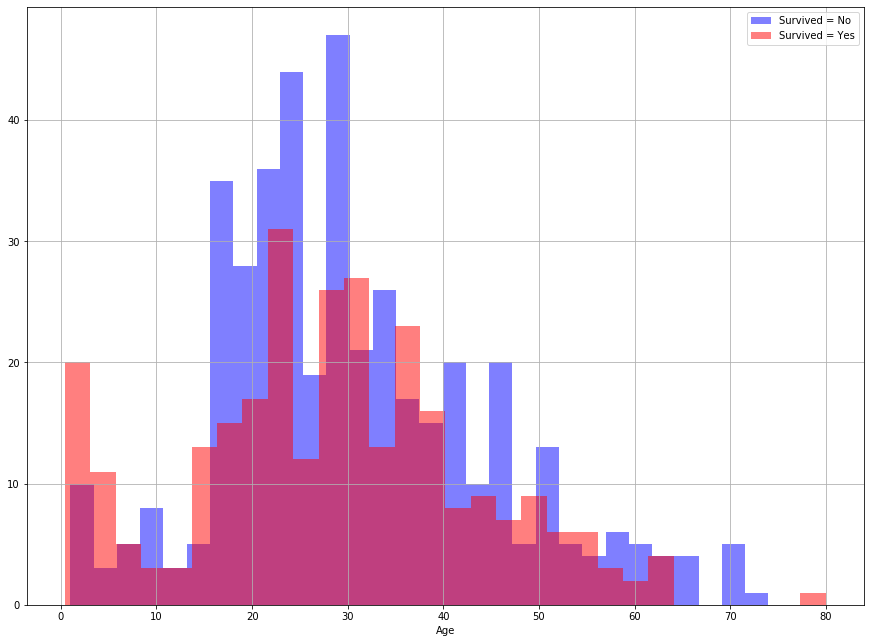

In [7]:
# Análise da coluna 'Survived' em relação a coluna 'Age'
plt.figure(figsize=(15, 11))
trainFile[trainFile['Survived']==0]['Age'].hist(alpha=0.5,color='blue', bins=30,label='Survived = No')
trainFile[trainFile['Survived']==1]['Age'].hist(alpha=0.5,color='red', bins=30,label='Survived = Yes')
plt.legend()
plt.xlabel('Age')

Text(0.5, 0, 'Fare')

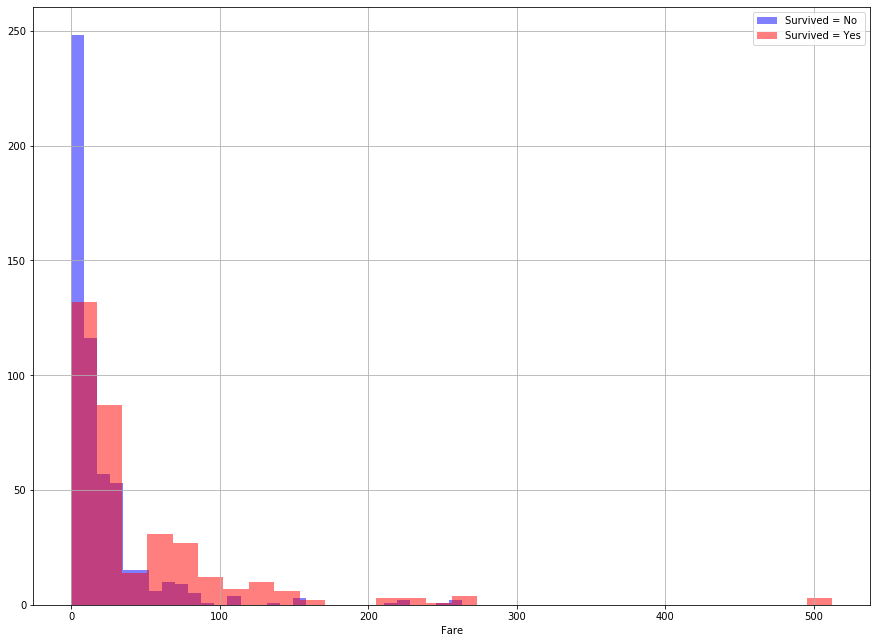

In [10]:
# Análise da coluna 'Survived' em relação a coluna 'Fare'
plt.figure(figsize=(15, 11))
trainFile[trainFile['Survived']==0]['Fare'].hist(alpha=0.5,color='blue', bins=30,label='Survived = No')
trainFile[trainFile['Survived']==1]['Fare'].hist(alpha=0.5,color='red', bins=30,label='Survived = Yes')
plt.legend()
plt.xlabel('Fare')

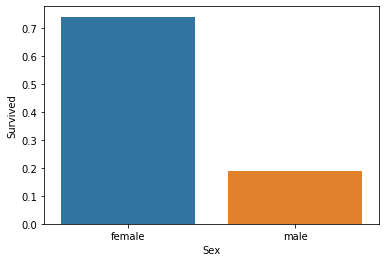

In [8]:
#Análise da porcentagem de passageiros sobreviventes de cada sexo
sexSurvivors = trainFile[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(y = sexSurvivors['Survived'], x = sexSurvivors['Sex'])

## 4. Tratamento de dados nulos

In [9]:
#Completando os dados faltantes em na coluna 'Embarked' com o valor mais comum da mesma.
trainFile['Embarked'].fillna('S', inplace = True)

#Mudança das variáveis do tipo objeto para numérico
        
trainFile['Sex'] = trainFile['Sex'].map({'female': 0, 'male': 1}).astype(int)
trainFile['Embarked'] = trainFile['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
print(trainFile.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         714 non-null float64
Fare        891 non-null float64
Embarked    891 non-null int32
dtypes: float64(2), int32(2), int64(2)
memory usage: 41.8 KB
None
